In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import json

## Load data

In [5]:
def read_bed(file):
    return pd.read_csv(file, sep='\t', header=None)

In [6]:
EXP_NAME = 'curax_14h_UNI_mm9'

In [7]:
data = read_bed(f'{EXP_NAME}.bed')
data.columns = ['chr', 'start', 'end']

data

,chr,start,end
0,chr1,4549822,4550312
1,chr1,5062248,5062630
2,chr1,6907202,6907470
3,chr1,8019995,8020610
4,chr1,9165646,9165931
...,...,...,...
1956,chrY_random,5277945,5278260
1957,chrY_random,11777722,11778059
1958,chrY_random,19640868,19641420
1959,chrY_random,28369780,28370118


## Filter out chromosomes with low data
Нам не нужны данные хромосом, где мало данных, типа chrX_random, поэтому их мы убираем

In [8]:
print(list(data.chr.value_counts().items()))

[('chrX', 192), ('chr6', 139), ('chr1', 133), ('chr3', 125), ('chr4', 118), ('chr7', 116), ('chr5', 114), ('chr2', 108), ('chr8', 102), ('chr10', 88), ('chr9', 86), ('chr17', 82), ('chr14', 80), ('chr13', 75), ('chr16', 73), ('chr11', 71), ('chr12', 70), ('chr15', 65), ('chr18', 62), ('chr19', 29), ('chrUn_random', 19), ('chrY_random', 6), ('chr8_random', 3), ('chr1_random', 2), ('chr9_random', 1), ('chrM', 1), ('chrY', 1)]


In [9]:
# Set threshold
threshold = 20

filtered_chroms = list(data.chr.value_counts()[data.chr.value_counts() > threshold].index)
data = data[sum(list((data.chr == chromosome) for chromosome in filtered_chroms)) == 1]

## Regions length statistics

In [10]:
# compute length
data['length'] = data.end - data.start
data['center'] = (data.end + data.start) // 2
data

/Users/art-temiy/opt/anaconda3/envs/bioinf/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/art-temiy/opt/anaconda3/envs/bioinf/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,chr,start,end,length,center
0,chr1,4549822,4550312,490,4550067
1,chr1,5062248,5062630,382,5062439
2,chr1,6907202,6907470,268,6907336
3,chr1,8019995,8020610,615,8020302
4,chr1,9165646,9165931,285,9165788
...,...,...,...,...,...
1949,chrX,166439843,166440321,478,166440082
1950,chrX,166441129,166441461,332,166441295
1951,chrX,166444078,166444501,423,166444289
1952,chrX,166527166,166527499,333,166527332


length mean (median in fact): 352.0
length std: 233.56105388190437
percentile 0.99: 1297.2200000000003
percentile 0.999: 2984.7030000000996
percentile 0.9995: 3323.18750000022
percentile 0.9999: 4383.037499999607


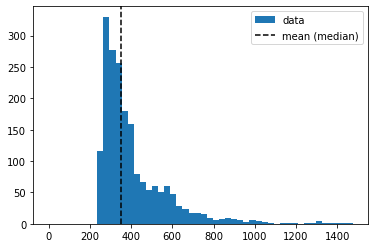

In [11]:
mean_len = data.length.median()
std_len = data.length.std()
print(f'length mean (median in fact): {mean_len}')
print(f'length std: {std_len}')
print(f'percentile 0.99: {data.length.quantile(0.99)}')
print(f'percentile 0.999: {data.length.quantile(0.999)}')
print(f'percentile 0.9995: {data.length.quantile(0.9995)}')
print(f'percentile 0.9999: {data.length.quantile(0.9999)}')

_ = plt.hist(data.length, range=(0, data.length.quantile(0.995)), bins=50, label='data')
_ = plt.axvline(mean_len, label='mean (median)', linestyle='--', c='k')
plt.legend()

## Distance between regions

In [12]:
data_by_chroms = {
    chr: data[data.chr == chr].sort_values(by='start')
    for chr in data.chr.value_counts().index
}

chrome: chrX ... 370
chrome: chr6 ... 127
chrome: chr1 ... 314
chrome: chr3 ... 277
chrome: chr4 ... 386
chrome: chr7 ... 857
chrome: chr5 ... 455
chrome: chr2 ... 241
chrome: chr8 ... 278
chrome: chr10 ... 252
chrome: chr9 ... 269
chrome: chr17 ... 396
chrome: chr14 ... 1008
chrome: chr13 ... 260
chrome: chr16 ... 329
chrome: chr11 ... 2428
chrome: chr12 ... 1400
chrome: chr15 ... 329
chrome: chr18 ... 735
chrome: chr19 ... 1975


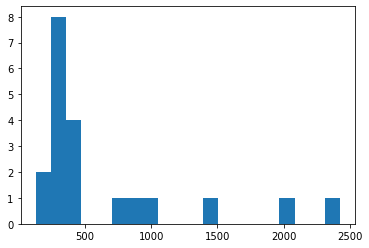

In [13]:
all_min_gaps = []
for chr, c_data in data_by_chroms.items():
    print(f'chrome: {chr}', end=' ... ')
    if (c_data.shape[0] < 2):
        print('***Skip***')
        continue
    gaps = np.array(c_data.start[1:]) - np.array(c_data.end[:-1])
    minimum_gap = gaps.min()
    all_min_gaps.append(minimum_gap)
    print(minimum_gap)

plt.hist(
    all_min_gaps,
    bins = len(all_min_gaps)
)
plt.show()
    

In [14]:
d = data_by_chroms['chr11']
g = (np.array(d.start[1:]) - np.array(d.end[:-1]))
print(np.sort(g))
np.percentile(g, 0), np.percentile(g, 5), np.percentile(g, 100), 

[   2428   15545   20881   33176   44755   52381   57420   99550  126399
  130854  159239  222239  230386  247334  250270  269652  320294  360538
  386314  398751  464042  495780  496205  512385  534220  545017  607589
  610787  663554  846629  865850  905649  956078 1101943 1140315 1168385
 1328025 1340164 1451162 1624196 1729164 1789555 1825214 1866891 1869155
 1970625 1973444 2025947 2046752 2080286 2106912 2174519 2233528 2259509
 2748992 2773497 2907274 2951275 3032549 3352781 3462158 3757708 3840628
 4226017 4485125 4615572 4985920 5051490 6536880 8824738]


(2428.0, 38386.55, 8824738.0)

## Settings global data params according to values above

In [15]:
# Set region_length and bins count
region_length = 1500
bins_count = 100

assert region_length % bins_count == 0, 'Wrong numbers, region_length % bins_count != 0'
bps_per_bin = region_length // bins_count

## Create and save final regions (discretized) and global data parameters

In [16]:
# Create regions
regions = pd.DataFrame()
regions['chr'] = data.chr
regions['start'] = data.center - region_length // 2
regions['end'] = data.center + region_length // 2
regions

,chr,start,end
0,chr1,4549317,4550817
1,chr1,5061689,5063189
2,chr1,6906586,6908086
3,chr1,8019552,8021052
4,chr1,9165038,9166538
...,...,...,...
1949,chrX,166439332,166440832
1950,chrX,166440545,166442045
1951,chrX,166443539,166445039
1952,chrX,166526582,166528082


In [17]:
# discretize
regions.start = regions.start // bps_per_bin * bps_per_bin
regions.end = regions.end // bps_per_bin * bps_per_bin

In [18]:
# Save regions
regions.to_csv(f'{EXP_NAME}.regions-unified.bed', sep='\t', header=None, index=None)

In [19]:
# Save global data parameters
json.dump(
    {
        'region_length': 1500,
        'bins_count': 100,
    },
    open('global_data_params.json', 'w+'),
    indent=4,
)